In [1]:
# if local use new_torch_env

import os

import numpy as np
import pandas as pd
# import seaborn as sns

from collections import Counter

import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from xml.etree import ElementTree, ElementInclude

import pickle
from functools import reduce

import detectron2

# remember: 
All thresholds were set at 0.1 in prediction scripts.  

> cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # set a custom testing threshold

If everything is over estimated, lower it. But this you can also do model specific! 


# testing:
Todo:

- import from all models - give varibles model identify
- make and merge dfs.
- Add train/test label
- Add annotated label...
- Explore...

MEN! Det er jo slet ikke alle de billede i den mappe der er kodet - men du har taget alle sammen... Du kan sortere fra bagefter så - hvis vherek nde optræder i test eller train idx..


# FULL
Todo:
- import from all models - give varibles model identify
- make and merge dfs.
- Explore...

In [2]:
def make_df(model, FULL = False):

    if FULL == False:

        output_list_path = f'/home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs_test/{model}/output_list.pkl' 
        all_img_feature_list_path = f'/home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs_test/{model}/all_img_feature_list.pkl' 
        # instances_path = f'/home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs_test/{model}/instances_list.pkl' 


    elif FULL == True:

        output_list_path = f'/home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs_test/{model}_FULL/output_list_FULL.pkl' 
        all_img_feature_list_path = f'/home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs_test/{model}/all_img_feature_list_FULL.pkl' 
        # instances_path = f'/home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs_test/{model}/instances_list_FULL.pkl'

    else:
        'wrong argument...'

    with open(output_list_path, 'rb') as file:
        outputs_list = pickle.load(file)

    with open(all_img_feature_list_path, 'rb') as file:
        all_img_feature_list = pickle.load(file)

    # with open(instances_path, 'rb') as file: # you anot useing this now...
    #     instances_list = pickle.load(file)

    all_img_feature_list = list(set(all_img_feature_list)) # get the unique set of features

    df_thick = pd.DataFrame(outputs_list).fillna(0)
    df_thick.iloc[:,3:] = df_thick.iloc[:,3:].astype('int') # counts as ints not floats 

    df_thin = df_thick[['img_id'] + all_img_feature_list].copy() # making a df with just feature counts and img_id


    # here u should add train/test label + annotation and sort away everything else > if FULL = False
    # if Full == False: # bit anoying that you have had thi before.. maby it goes in it own function...

    #     train_test_index_path = '/home/simon/Documents/Bodies/scripts/OD/Detectron2/misc/train_test_index.pkl' # remenber to get to the right one on computerome
    #     #train_test_index_path = '/home/simon/Documents/Bodies/scripts/OD/Detectron2/misc/train_test_index.pkl' 


    #     with open(train_test_index_path, 'rb') as file:
    #         train_test_index_path = pickle.load(file)


    monkier_dict = {'faster_rcnn_R_50_FPN_3x' : 'fasterR50', 
                'faster_rcnn_R_101_FPN_3x' : 'fasterR101', 
                'faster_rcnn_X_101_32x8d_FPN_3x' : 'fasterX101',
                'retinanet_R_50_FPN_3x' : 'retinaR50',
                'retinanet_R_101_FPN_3x' : 'retinaR101'} 

    # sumb correction to help further down..
    df_thin.rename(columns={'flag_us':'flagUS'}, inplace= True)
    df_thin.rename(columns={'flag_iraqi':'falgIRQ'}, inplace= True)

    for old_name in df_thin.columns[1:]: # we do not change name image ID


        monkier = monkier_dict[model]
        new_name = f'{old_name}_{monkier}'
        df_thin.rename(columns={old_name:new_name}, inplace= True)

    return(df_thin)
    

In [3]:
def add_train_test_info(df_merged):

    train_test_index_path = '/home/simon/Documents/Bodies/scripts/OD/Detectron2/misc/train_test_index.pkl' # remenber to get to the right one on computerome
    #train_test_index_path = '/home/simon/Documents/Bodies/scripts/OD/Detectron2/misc/train_test_index.pkl' 

    with open(train_test_index_path, 'rb') as file:
        train_test_index_path = pickle.load(file)

    train_idx = pd.Series(train_test_index_path['train']).str.replace('.xml', '')
    test_idx = pd.Series(train_test_index_path['test']).str.replace('.xml', '')

    df_merged['train'] = df_merged['img_id'].isin(train_idx).astype('int')
    df_merged['test'] = df_merged['img_id'].isin(test_idx).astype('int')

    df_sub = df_merged[(df_merged['test'] == 1) | (df_merged['train'] == 1)]

    return(df_sub)

In [4]:
def make_df_merge(FULL = False):

    df_faster_rcnn_R_50_FPN_3x = make_df('faster_rcnn_R_50_FPN_3x', FULL = False)
    df_faster_rcnn_R_101_FPN_3x = make_df('faster_rcnn_R_101_FPN_3x', FULL = False)
    df_faster_rcnn_X_101_32x8d_FPN_3x = make_df('faster_rcnn_X_101_32x8d_FPN_3x', FULL = False)
    df_retinanet_R_50_FPN_3x = make_df('retinanet_R_50_FPN_3x', FULL = False)
    df_retinanet_R_101_FPN_3x = make_df('retinanet_R_101_FPN_3x', FULL = False)


    data_frames = [df_faster_rcnn_R_50_FPN_3x, df_faster_rcnn_R_101_FPN_3x, 
                df_faster_rcnn_X_101_32x8d_FPN_3x, df_retinanet_R_50_FPN_3x, 
                df_retinanet_R_101_FPN_3x]

    df_merged = reduce(lambda left,right: pd.merge(left,right,on=['img_id'], how='outer'), data_frames)    

    if FULL == False:
        df_merged = add_train_test_info(df_merged)

    return(df_merged)

In [5]:
def plot_corr(df_merged):

    front_str_list = []
    for i in df_merged.columns:
        front_str_list.append(i.split('_')[0])

    features = set(front_str_list)

    # -------------------------

    for i in features:

        temp_df = df_merged.loc[:,df_merged.columns.str.startswith(i)]


        if temp_df.shape[1]>1: # more than one column; this solves a lot.

            sns.pairplot(temp_df)
            plt.show()

In [6]:
df_merged = make_df_merge()

/tmp/ipykernel_1325122/1650631829.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  train_idx = pd.Series(train_test_index_path['train']).str.replace('.xml', '')
/tmp/ipykernel_1325122/1650631829.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  test_idx = pd.Series(train_test_index_path['test']).str.replace('.xml', '')


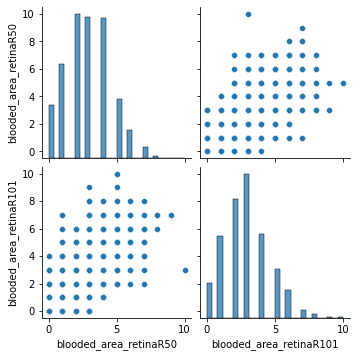

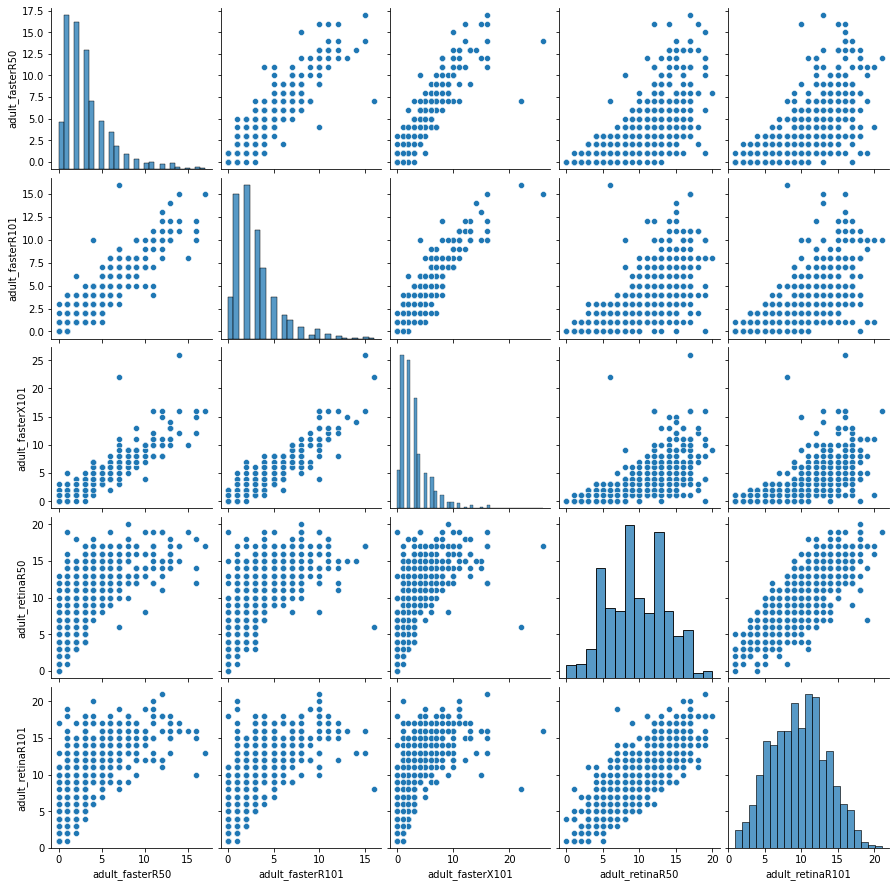

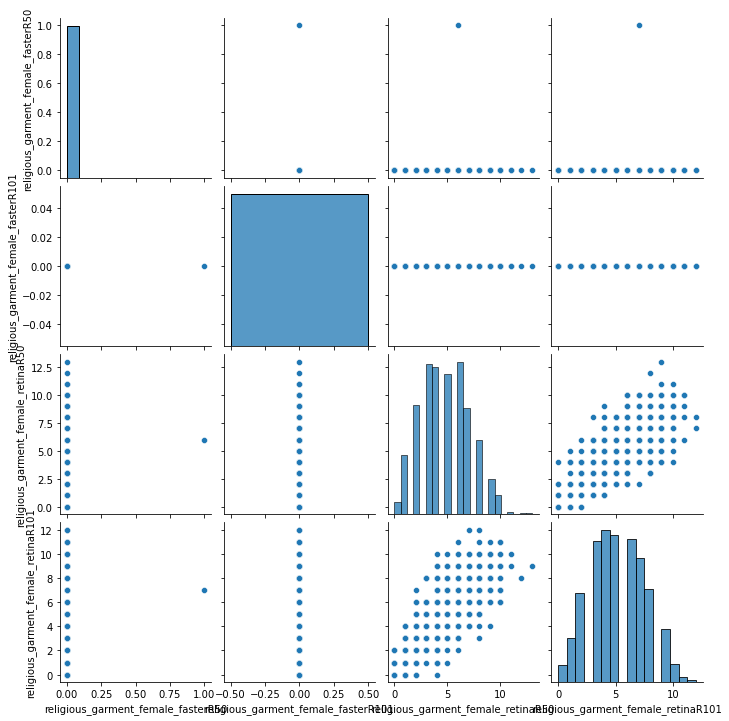

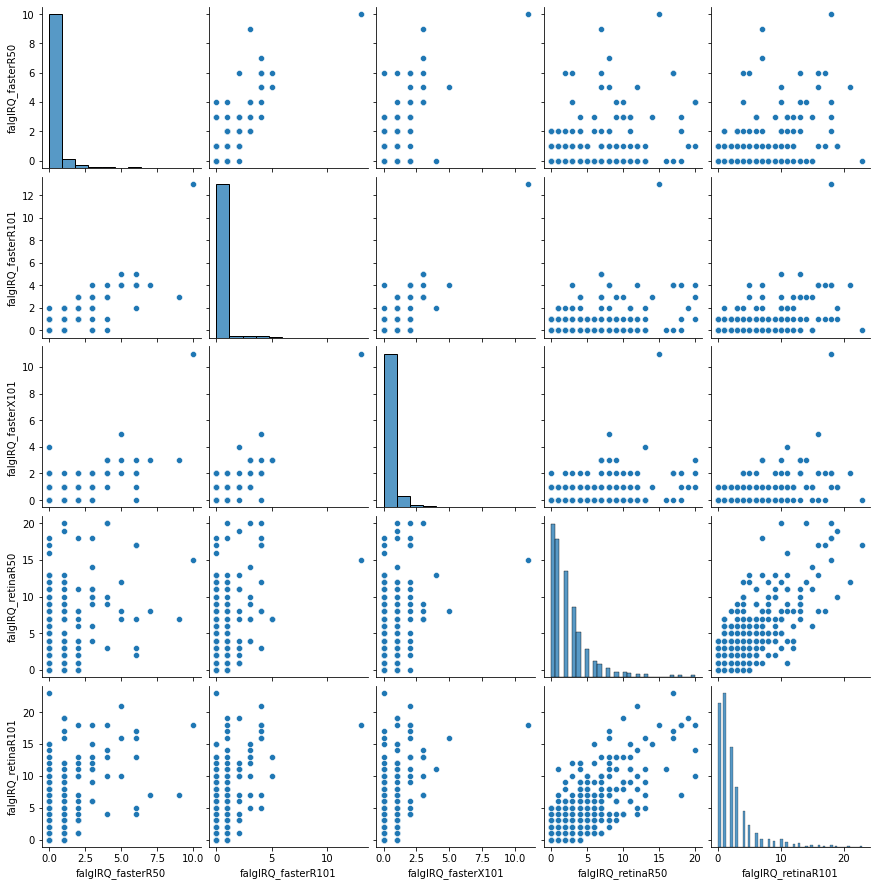

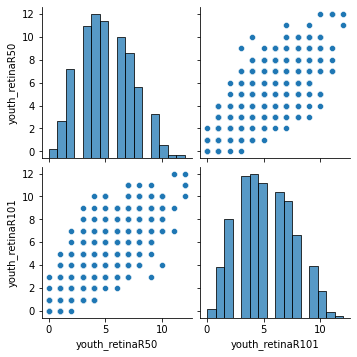

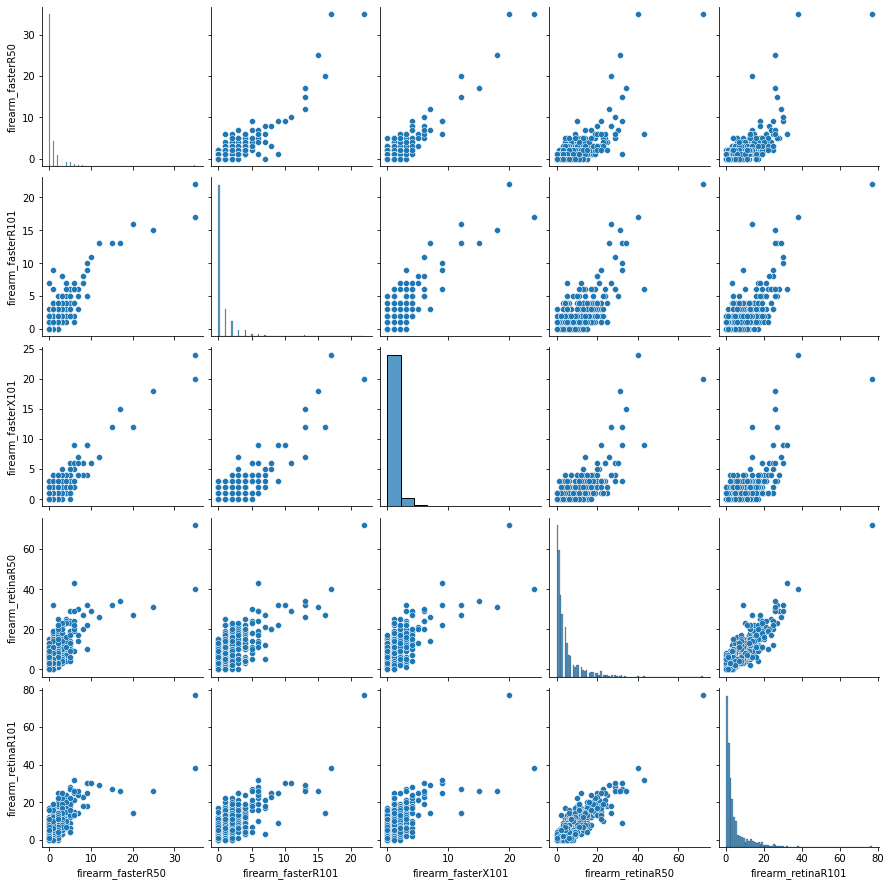

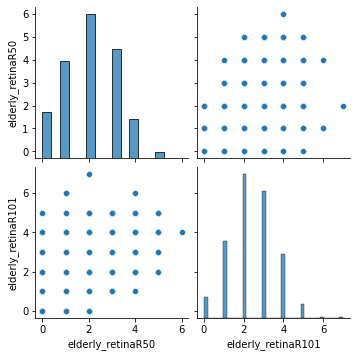

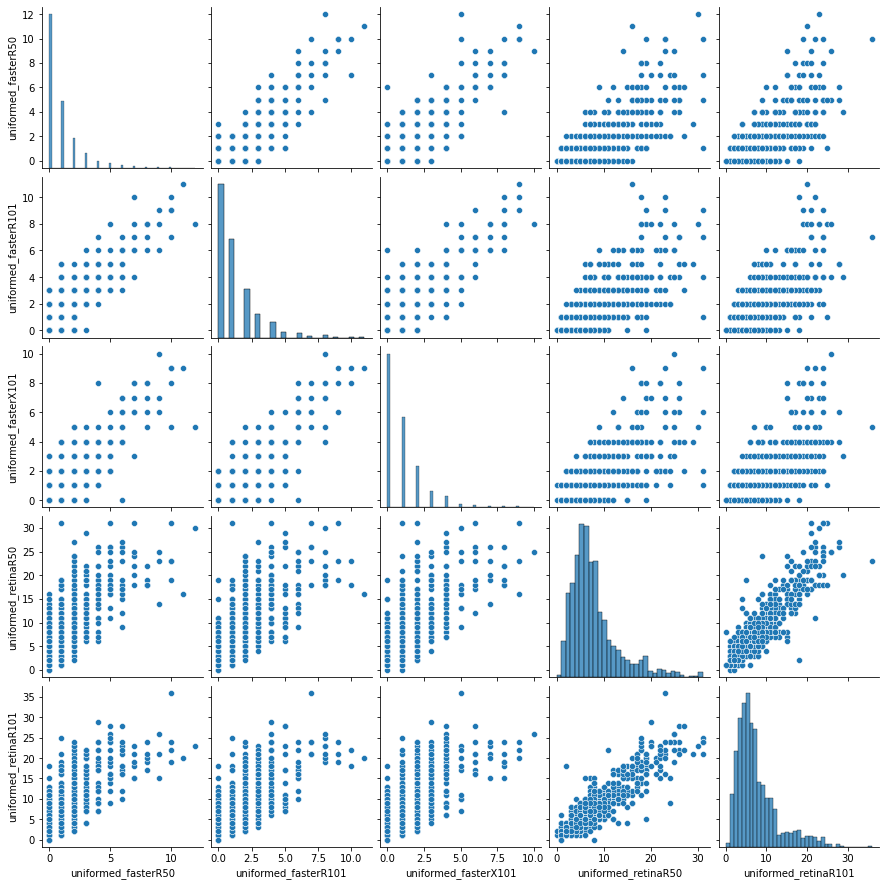

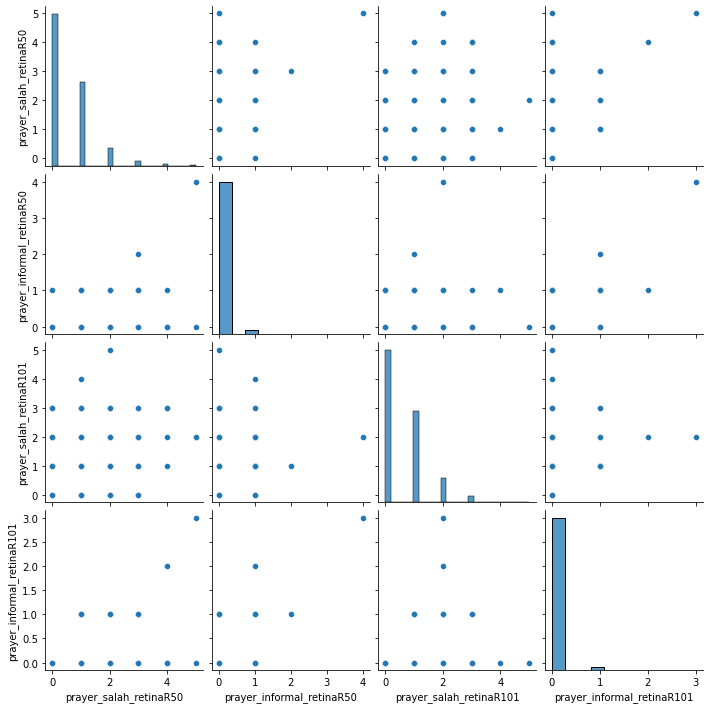

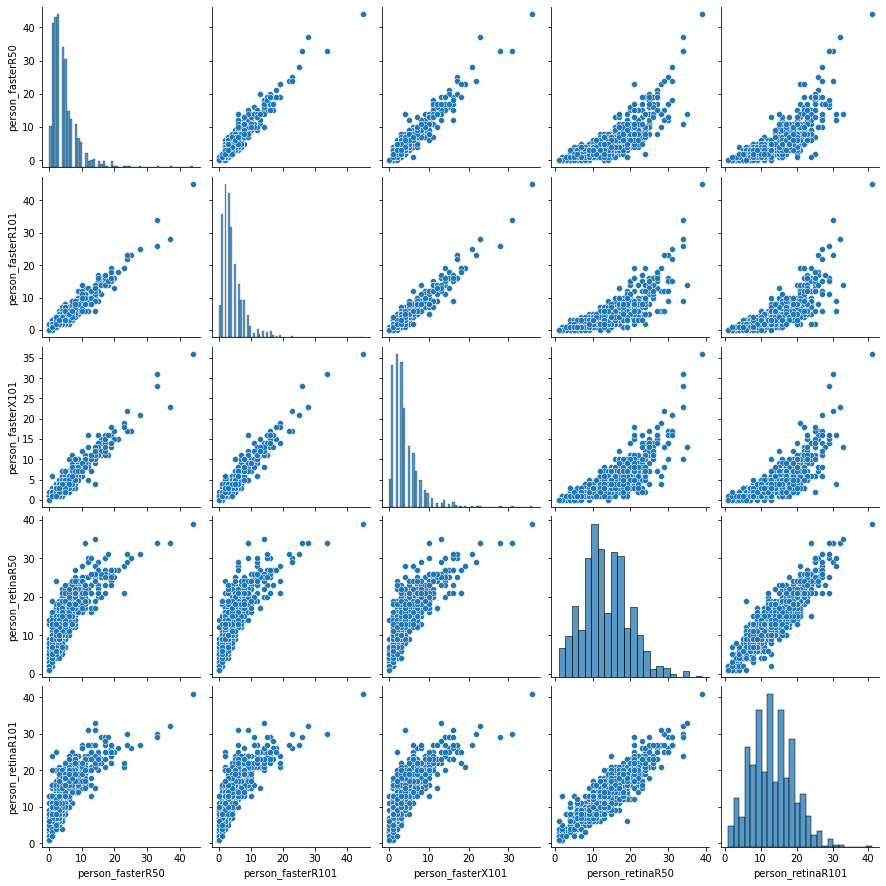

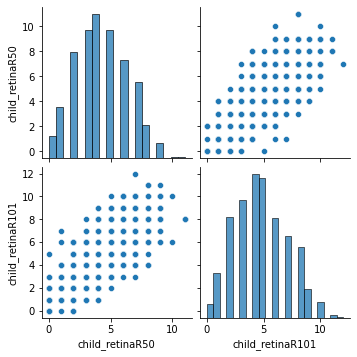

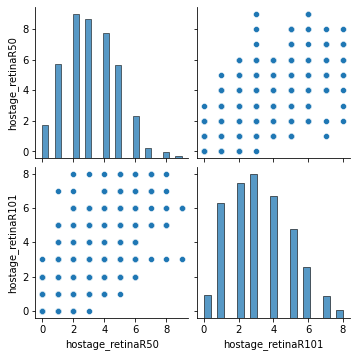

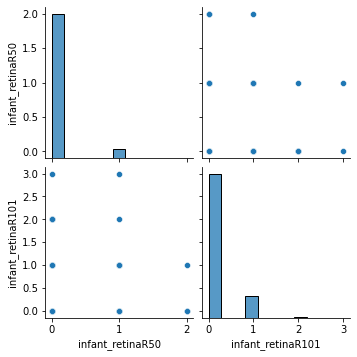

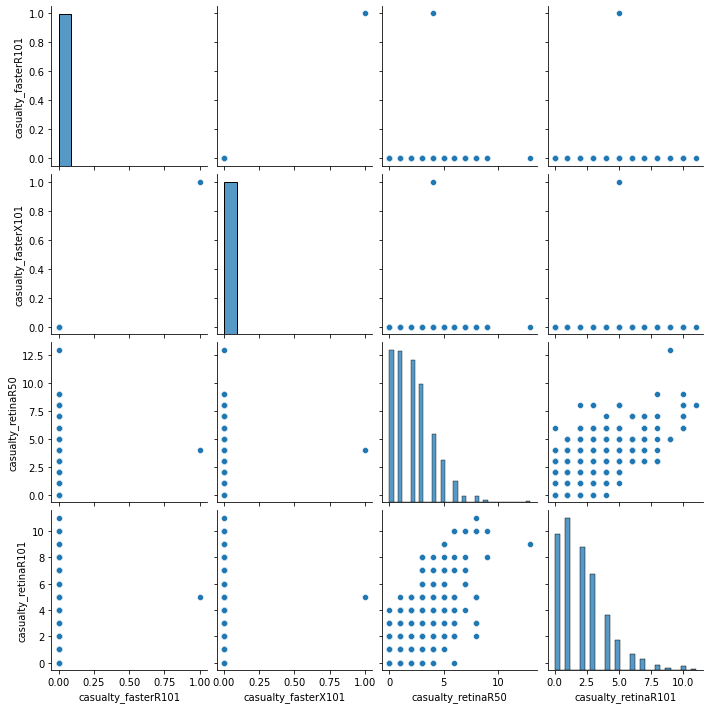

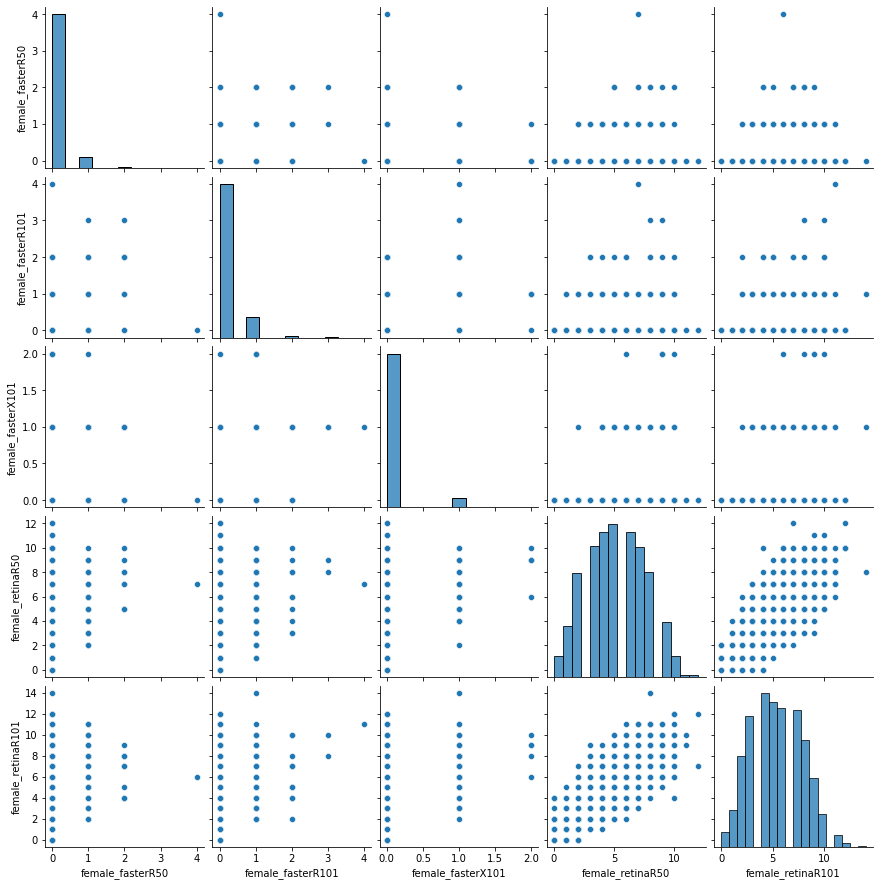

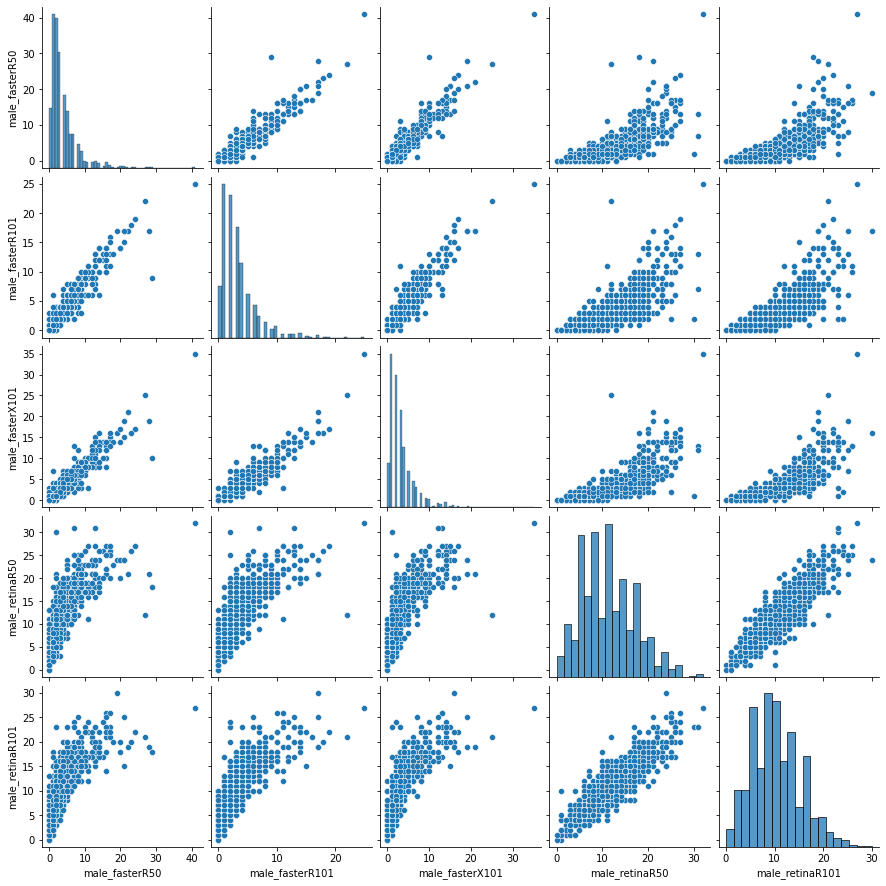

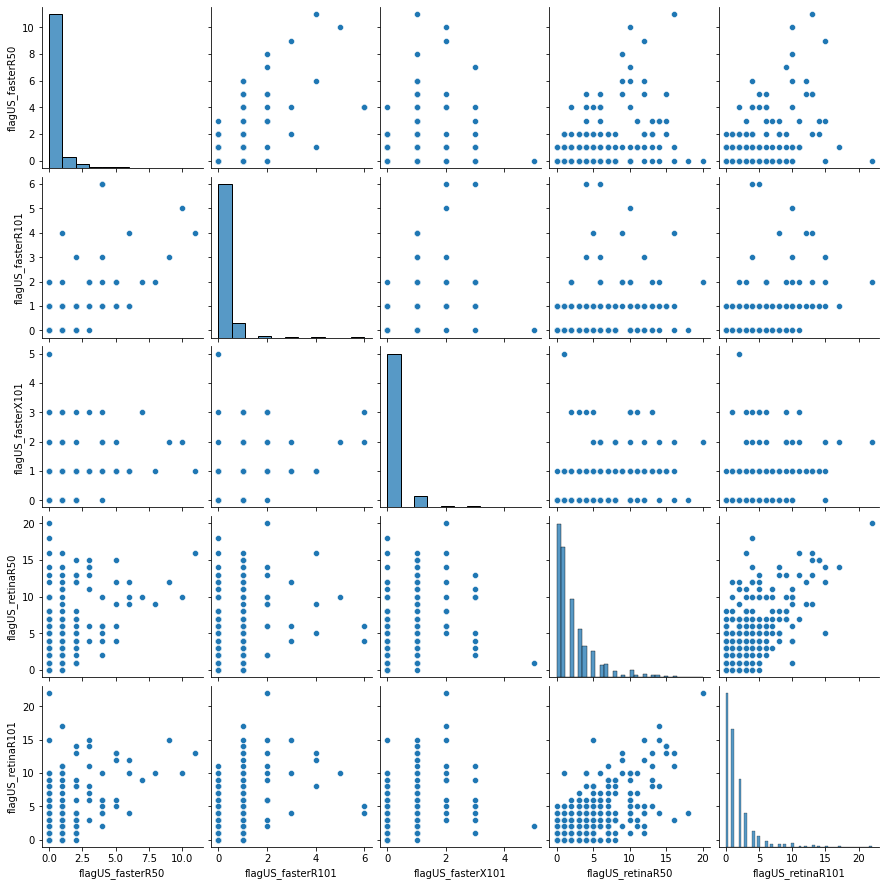

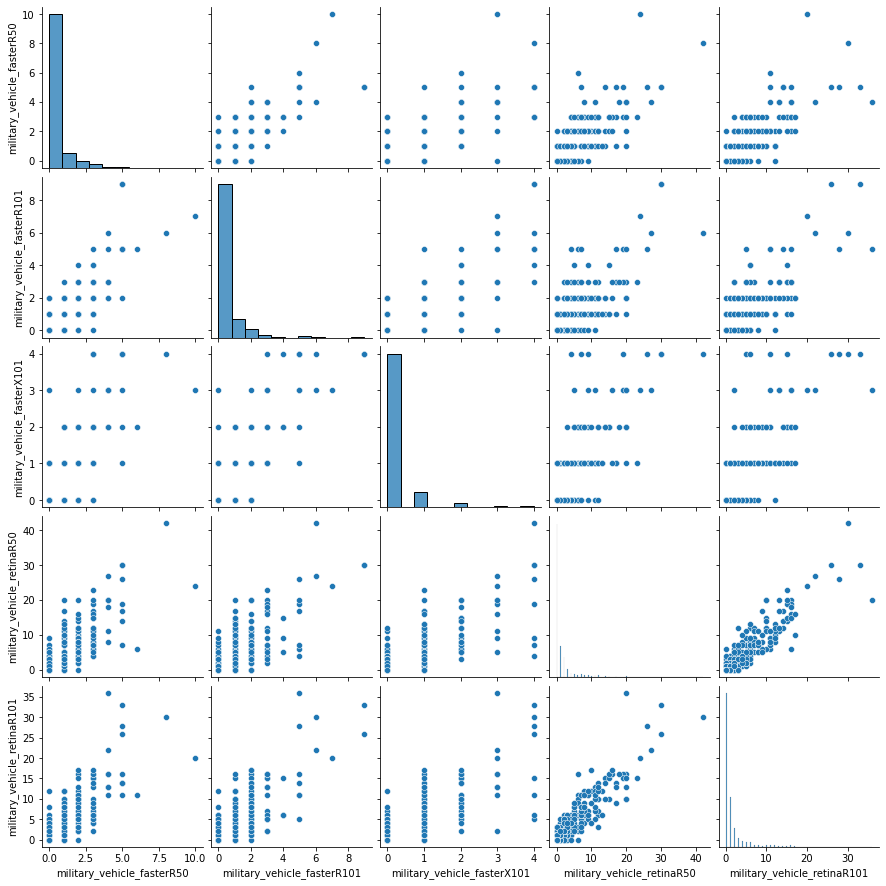

In [7]:
plot_corr(df_merged)

In [ ]:
# OLD

In [7]:

train_test_index_path = '/home/simon/Documents/Bodies/scripts/OD/Detectron2/misc/train_test_index.pkl' # remenber to get to the right one on computerome
#train_test_index_path = '/home/simon/Documents/Bodies/scripts/OD/Detectron2/misc/train_test_index.pkl' 


with open(train_test_index_path, 'rb') as file:
    train_test_index_path = pickle.load(file)

In [25]:
train_idx = pd.Series(train_test_index_path['train']).str.replace('.xml', '')
test_idx = pd.Series(train_test_index_path['test']).str.replace('.xml', '')

df_merged['train'] = df_merged['img_id'].isin(train_idx).astype('int')
df_merged['test'] = df_merged['img_id'].isin(test_idx).astype('int')

df_sub = df_merged[(df_merged['test'] == 1) | (df_merged['train'] == 1)]

/tmp/ipykernel_1303667/1473963014.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_idx = pd.Series(train_test_index_path['train']).str.replace('.xml', '')
/tmp/ipykernel_1303667/1473963014.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_idx = pd.Series(train_test_index_path['test']).str.replace('.xml', '')


In [38]:
df_merged[(df_merged['test'] == 1) | (df_merged['train'] == 1)]

,img_id,male_fasterR50,uniformed_fasterR50,flag_us_fasterR50,military_vehicle_fasterR50,flag_iraqi_fasterR50,female_fasterR50,firearm_fasterR50,person_fasterR50,adult_fasterR50,...,religious_garment_female_retinaR101,male_retinaR101,blooded_area_retinaR101,uniformed_retinaR101,flag_us_retinaR101,person_retinaR101,infant_retinaR101,adult_retinaR101,train,test
2,JS9617,7,1,1,0,0,0,4,10,9,...,7,13,3,11,1,19,0,12,1,0
4,JS12373,7,0,1,0,0,0,0,10,6,...,6,14,4,13,2,18,0,14,1,0
7,JS37420,1,1,1,0,1,0,0,1,2,...,2,4,3,4,4,6,0,6,1,0
19,JS20086,8,1,0,0,0,0,0,8,7,...,9,17,3,7,3,17,0,12,1,0
27,JS43977,2,2,0,0,0,0,2,4,3,...,3,12,5,11,2,15,0,10,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4984,JS43601,2,2,0,0,0,0,0,2,2,...,2,6,2,14,2,11,0,9,1,0
4985,JS20361,6,0,0,0,0,0,1,8,5,...,6,14,2,9,1,19,0,14,0,1
4987,JS5195,1,0,0,0,0,0,0,2,1,...,3,6,3,2,1,8,0,4,1,0
4996,JS14721,5,2,0,0,0,0,0,7,5,...,9,10,5,7,3,14,0,10,0,1


In [30]:
df_merged['test']

0       0
1       0
2       0
3       0
4       0
       ..
4994    0
4995    0
4996    1
4997    0
4998    0
Name: test, Length: 4999, dtype: int64

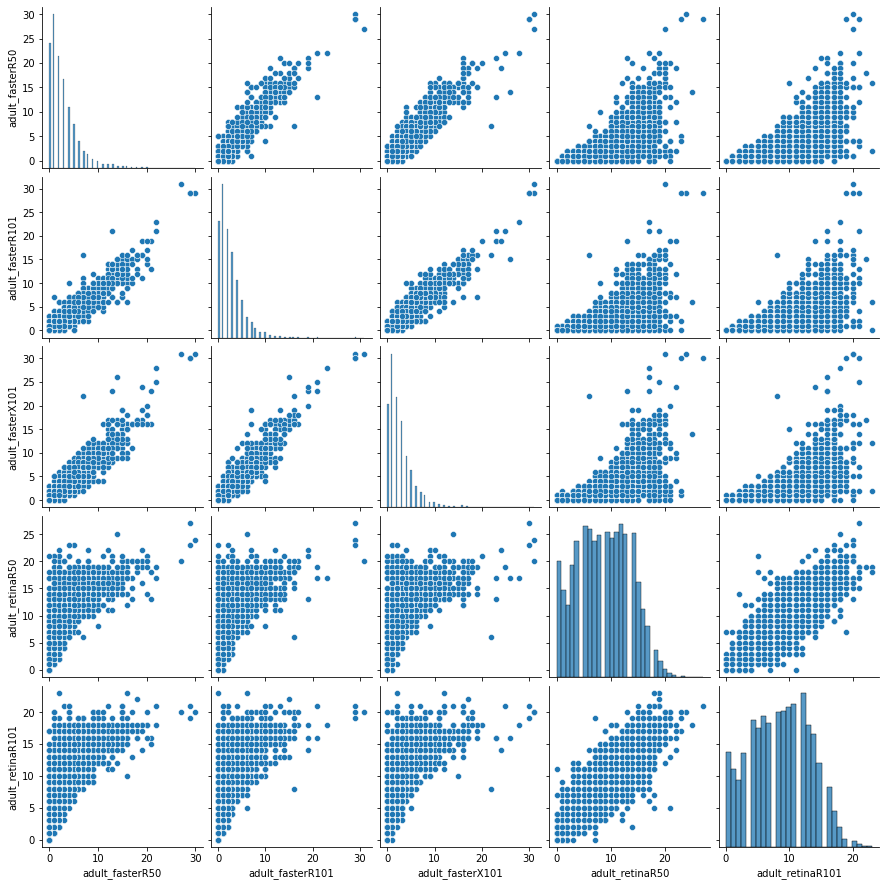

In [31]:
sns.pairplot(df_adult)
plt.show()

,adult_fasterR50
0,7
1,0
2,9
3,10
4,6
...,...
4994,0
4995,2
4996,5
4997,2


In [12]:
df_faster_rcnn_R_101_FPN_3x

,img_id,adult_fasterR101,religious_garment_female_fasterR101,flag_us_fasterR101,firearm_fasterR101,uniformed_fasterR101,casualty_fasterR101,military_vehicle_fasterR101,person_fasterR101,female_fasterR101,male_fasterR101,flag_iraqi_fasterR101
0,JS151934,8,0,1,0,0,0,0,9,2,7,0
1,JS149295,1,0,0,0,6,0,0,5,0,0,0
2,JS9617,5,0,0,4,3,0,0,7,0,6,0
3,JS45619,10,0,0,0,1,0,0,13,0,11,0
4,JS12373,6,0,1,1,1,0,0,8,0,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4994,JS86560,0,0,0,0,0,0,1,0,0,0,0
4995,JS103806,2,0,0,0,0,0,0,2,0,2,0
4996,JS14721,4,0,0,0,0,0,0,6,0,3,0
4997,JS11072,2,0,0,0,0,0,0,3,1,2,0


In [13]:
df_faster_rcnn_X_101_32x8d_FPN_3x

,img_id,adult_fasterX101,flag_us_fasterX101,firearm_fasterX101,uniformed_fasterX101,casualty_fasterX101,military_vehicle_fasterX101,person_fasterX101,female_fasterX101,male_fasterX101,flag_iraqi_fasterX101
0,JS151934,7,0,0,0,0,0,10,1,8,0
1,JS149295,0,0,0,5,0,0,5,0,0,0
2,JS9617,6,0,3,1,0,0,7,0,7,0
3,JS45619,10,0,0,0,0,0,10,0,10,0
4,JS12373,4,1,0,0,0,0,7,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...
4994,JS86560,0,0,1,0,0,1,0,0,0,0
4995,JS103806,2,0,0,1,0,0,3,0,2,0
4996,JS14721,6,0,0,0,0,0,6,0,5,0
4997,JS11072,1,0,0,0,0,0,3,0,1,0


In [14]:
df_retinanet_R_50_FPN_3x

,img_id,youth_retinaR50,male_retinaR50,religious_garment_female_retinaR50,prayer_informal_retinaR50,flag_us_retinaR50,uniformed_retinaR50,child_retinaR50,person_retinaR50,firearm_retinaR50,flag_iraqi_retinaR50,prayer_salah_retinaR50,adult_retinaR50,elderly_retinaR50,hostage_retinaR50,casualty_retinaR50,military_vehicle_retinaR50,infant_retinaR50,blooded_area_retinaR50,female_retinaR50
0,JS151934,7,16,10,0,1,7,9,17,0,0,0,12,5,3,1,0,0,3,9
1,JS149295,4,7,4,0,0,35,4,12,9,0,0,7,4,7,0,2,0,3,2
2,JS9617,7,16,5,0,1,10,6,21,6,1,0,14,1,3,0,0,0,2,7
3,JS45619,9,23,5,0,0,4,8,23,0,0,0,16,2,2,0,0,0,1,7
4,JS12373,6,15,5,0,9,8,5,16,3,2,0,12,4,4,0,0,0,4,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,JS86560,1,1,1,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1
4995,JS103806,5,9,3,0,0,3,5,7,0,0,1,7,4,4,1,0,0,3,5
4996,JS14721,6,12,7,0,7,7,5,13,0,8,1,13,3,3,3,1,0,3,8
4997,JS11072,4,11,6,0,4,6,5,10,6,1,1,8,3,3,3,0,0,6,7


In [15]:
df_retinanet_R_101_FPN_3x

,img_id,youth_retinaR101,male_retinaR101,religious_garment_female_retinaR101,flag_us_retinaR101,prayer_informal_retinaR101,uniformed_retinaR101,child_retinaR101,person_retinaR101,firearm_retinaR101,flag_iraqi_retinaR101,adult_retinaR101,prayer_salah_retinaR101,elderly_retinaR101,hostage_retinaR101,casualty_retinaR101,military_vehicle_retinaR101,female_retinaR101,blooded_area_retinaR101,infant_retinaR101
0,JS151934,9,13,10,0,0,6,10,17,0,0,14,0,3,5,2,0,10,1,0
1,JS149295,4,9,1,0,0,35,3,11,13,0,7,2,4,6,0,1,3,1,0
2,JS9617,7,13,7,1,0,11,5,19,7,0,12,0,3,5,0,0,7,3,0
3,JS45619,9,19,8,0,0,5,9,23,0,0,14,0,2,2,0,0,8,1,0
4,JS12373,6,14,6,2,0,13,4,18,3,2,14,0,4,6,0,0,4,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,JS86560,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,5,1,1,0
4995,JS103806,4,7,3,0,0,3,3,8,0,0,6,0,3,2,2,0,4,2,0
4996,JS14721,5,10,9,3,0,7,5,14,1,8,10,0,4,4,5,2,8,5,0
4997,JS11072,5,7,7,6,0,5,4,13,1,4,9,1,3,2,5,0,5,6,0


In [55]:
model = "retinanet_R_101_FPN_3x"
model.split('_')[0] + model.split('_')[-4]  + model.split('_')[-3]

'retinanetR101'

In [54]:
model = "faster_rcnn_R_50_FPN_3x"
model.split('_')[0] + model.split('_')[-4]  + model.split('_')[-3]

'fasterR50'

In [66]:
df_faster_rcnn_X_101_32x8d_FPN_3x

model = "faster_rcnn_X_101_32x8d_FPN_3x"
model.split('_')[0] + model.split('_')[-4]  + model.split('_')[-3]

'faster10132x8d'

In [69]:
monkier_dict['faster_rcnn_X_101_32x8d_FPN_3x']

'fasterX101'

In [39]:
model = 'faster_rcnn_R_50_FPN_3x'

for i,j in enumerate(df_faster_rcnn_R_50_FPN_3x.columns):
    monkier = model.split('_')[0] + model.split('_')[2]  + model.split('_')[3]
    new_name = f'{j}_{monkier}'
    df_faster_rcnn_R_50_FPN_3x.rename(columns={j:new_name}, inplace= True)

In [40]:
df_faster_rcnn_R_50_FPN_3x.columns

Index(['img_id_fasterR50', 'flag_iraqi_fasterR50', 'adult_fasterR50',
       'male_fasterR50', 'firearm_fasterR50', 'person_fasterR50',
       'religious_garment_female_fasterR50', 'uniformed_fasterR50',
       'female_fasterR50', 'military_vehicle_fasterR50', 'flag_us_fasterR50'],
      dtype='object')

In [ ]:
df.rename(columns={"OldName":"NewName"})

In [20]:
df_faster_rcnn_R_50_FPN_3x.rename(columns={'img_id':'Img_id'})

,Img_id,flag_iraqi,adult,male,firearm,person,religious_garment_female,uniformed,female,military_vehicle,flag_us
0,JS151934,0,7,10,0,10,0,0,0,0,1
1,JS149295,0,0,0,0,3,0,5,0,1,0
2,JS9617,0,9,7,4,10,0,1,0,0,1
3,JS45619,0,10,9,1,10,0,1,0,0,0
4,JS12373,0,6,7,0,10,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
4994,JS86560,0,0,0,1,0,0,0,0,1,0
4995,JS103806,0,2,2,0,3,0,0,0,0,0
4996,JS14721,0,5,5,0,7,0,2,0,0,0
4997,JS11072,0,2,2,0,3,0,0,0,0,0


In [17]:
j

'flag_us'

In [31]:
test_df

,img_id,military_vehicle,flag_us,casualty,religious_garment_female,female,adult,uniformed,flag_iraqi,male,firearm,person
0,JS151934,0,1,0,0,2,8,0,0,7,0,9
1,JS149295,0,0,0,0,0,1,6,0,0,0,5
2,JS9617,0,0,0,0,0,5,3,0,6,4,7
3,JS45619,0,0,0,0,0,10,1,0,11,0,13
4,JS12373,0,1,0,0,0,6,1,0,6,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...
4994,JS86560,1,0,0,0,0,0,0,0,0,0,0
4995,JS103806,0,0,0,0,0,2,0,0,2,0,2
4996,JS14721,0,0,0,0,0,4,0,0,3,0,6
4997,JS11072,0,0,0,0,1,2,0,0,2,0,3


In [32]:
df_thin

,img_id,military_vehicle,flag_us,religious_garment_female,female,adult,uniformed,flag_iraqi,firearm,male,person
0,JS151934,0,1,0,0,7,0,0,0,10,10
1,JS149295,1,0,0,0,0,5,0,0,0,3
2,JS9617,0,1,0,0,9,1,0,4,7,10
3,JS45619,0,0,0,0,10,1,0,1,9,10
4,JS12373,0,1,0,0,6,0,0,0,7,10
...,...,...,...,...,...,...,...,...,...,...,...
4994,JS86560,1,0,0,0,0,0,0,1,0,0
4995,JS103806,0,0,0,0,2,0,0,0,2,3
4996,JS14721,0,0,0,0,5,2,0,0,5,7
4997,JS11072,0,0,0,0,2,0,0,0,2,3


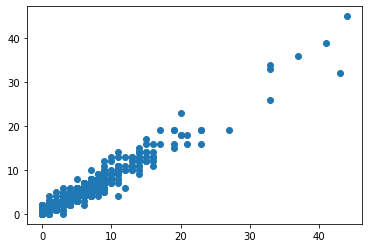

In [33]:
x = df_thin['person'][0:1000]
y = test_df['person'][0:1000]

plt.scatter(x,y)
plt.show()

In [34]:
output_list_path = '/home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs_test/faster_rcnn_R_50_FPN_3x/output_list.pkl' 

with open(output_list_path, 'rb') as file:
    outputs_list = pickle.load(file)

all_img_feature_list_path = '/home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs_test/faster_rcnn_R_50_FPN_3x/all_img_feature_list.pkl' 

with open(all_img_feature_list_path, 'rb') as file:
    all_img_feature_list = pickle.load(file)

instances_path = '/home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs_test/faster_rcnn_R_50_FPN_3x/instances_list.pkl' 

with open(instances_path, 'rb') as file:
    instances_list = pickle.load(file)

In [35]:
output_list_path = '/home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs_test/faster_rcnn_R_101_FPN_3x/output_list.pkl' 

with open(output_list_path, 'rb') as file:
    outputs_list = pickle.load(file)

all_img_feature_list_path = '/home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs_test/faster_rcnn_R_101_FPN_3x/all_img_feature_list.pkl' 

with open(all_img_feature_list_path, 'rb') as file:
    all_img_feature_list = pickle.load(file)

instances_path = '/home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs_test/faster_rcnn_R_101_FPN_3x/instances_list.pkl' 

with open(instances_path, 'rb') as file:
    instances_list = pickle.load(file)

In [36]:
output_list_path = '/home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs_test/faster_rcnn_X_101_32x8d_FPN_3x/output_list.pkl' 

with open(output_list_path, 'rb') as file:
    outputs_list = pickle.load(file)

all_img_feature_list_path = '/home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs_test/faster_rcnn_X_101_32x8d_FPN_3x/all_img_feature_list.pkl' 

with open(all_img_feature_list_path, 'rb') as file:
    all_img_feature_list = pickle.load(file)

instances_path = '/home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs_test/faster_rcnn_X_101_32x8d_FPN_3x/instances_list.pkl' 

with open(instances_path, 'rb') as file:
    instances_list = pickle.load(file)

In [37]:
output_list_path = '/home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs_test/retinanet_R_50_FPN_3x/output_list.pkl' 

with open(output_list_path, 'rb') as file:
    outputs_list = pickle.load(file)

all_img_feature_list_path = '/home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs_test/retinanet_R_50_FPN_3x/all_img_feature_list.pkl' 

with open(all_img_feature_list_path, 'rb') as file:
    all_img_feature_list = pickle.load(file)

instances_path = '/home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs_test/retinanet_R_50_FPN_3x/instances_list.pkl' 

with open(instances_path, 'rb') as file:
    instances_list = pickle.load(file)

In [38]:
output_list_path = '/home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs_test/retinanet_R_101_FPN_3x/output_list.pkl' 

with open(output_list_path, 'rb') as file:
    outputs_list = pickle.load(file)

all_img_feature_list_path = '/home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs_test/retinanet_R_101_FPN_3x/all_img_feature_list.pkl' 

with open(all_img_feature_list_path, 'rb') as file:
    all_img_feature_list = pickle.load(file)

instances_path = '/home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs_test/retinanet_R_101_FPN_3x/instances_list.pkl' 

with open(instances_path, 'rb') as file:
    instances_list = pickle.load(file)

In [39]:
all_img_feature_list = list(set(all_img_feature_list)) # get the unique set of features

df_thick = pd.DataFrame(outputs_list).fillna(0)
df_thick.iloc[:,3:] = df_thick.iloc[:,3:].astype('int') # counts as ints not floats 

df_thin = df_thick[['img_id'] + all_img_feature_list].copy() # making a df with just feature counts and img_id

In [40]:
df_thin

,img_id,military_vehicle,hostage,youth,blooded_area,flag_iraqi,elderly,casualty,child,adult,uniformed,person,flag_us,firearm,male,prayer_informal,infant,religious_garment_female,female,prayer_salah
0,JS151934,0,5,9,1,0,3,2,10,14,6,17,0,0,13,0,0,10,10,0
1,JS149295,1,6,4,1,0,4,0,3,7,35,11,0,13,9,0,0,1,3,2
2,JS9617,0,5,7,3,0,3,0,5,12,11,19,1,7,13,0,0,7,7,0
3,JS45619,0,2,9,1,0,2,0,9,14,5,23,0,0,19,0,0,8,8,0
4,JS12373,0,6,6,4,2,4,0,4,14,13,18,2,3,14,0,0,6,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,JS86560,5,1,0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1
4995,JS103806,0,2,4,2,0,3,2,3,6,3,8,0,0,7,0,0,3,4,0
4996,JS14721,2,4,5,5,8,4,5,5,10,7,14,3,1,10,0,0,9,8,0
4997,JS11072,0,2,5,6,4,3,5,4,9,5,13,6,1,7,0,0,7,5,1


In [41]:
df_thick

,img_id,scores,pred_classes,13,11,0,5,16,3,18,...,prayer_salah,military_vehicle,8,flag_us,7,flag_iraqi,10,infant,14,prayer_informal
0,JS151934,"[0.50052226, 0.4508566, 0.43484658, 0.43036255...","[13, 13, 11, 11, 13, 11, 13, 11, 0, 0, 0, 13, ...",17,13,14,10,10,10,9,...,0,0,0,0,0,0,0,0,0,0
1,JS149295,"[0.65109015, 0.51514566, 0.5074407, 0.464475, ...","[17, 17, 13, 17, 17, 17, 13, 13, 13, 11, 13, 0...",11,9,7,3,1,3,4,...,2,1,0,0,0,0,0,0,0,0
2,JS9617,"[0.7155502, 0.5457599, 0.50113773, 0.49588683,...","[6, 13, 11, 13, 13, 13, 11, 6, 13, 0, 13, 17, ...",19,13,12,7,7,5,7,...,0,0,1,1,0,0,0,0,0,0
3,JS45619,"[0.4982574, 0.42616066, 0.4246491, 0.41911012,...","[13, 13, 13, 13, 13, 11, 11, 13, 11, 11, 13, 1...",23,19,14,8,8,9,9,...,0,0,0,0,0,0,0,0,0,0
4,JS12373,"[0.4386505, 0.4096104, 0.40637854, 0.40495446,...","[13, 13, 13, 13, 17, 11, 11, 11, 0, 8, 17, 11,...",18,14,14,4,6,4,6,...,0,0,2,2,2,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,JS86560,"[0.84854, 0.50528544, 0.28726032, 0.2752539, 0...","[12, 6, 7, 2, 0, 13, 1, 17, 9, 11, 4, 3, 15, 1...",1,1,1,1,1,1,0,...,1,5,1,1,1,1,0,0,1,1
4995,JS103806,"[0.51036686, 0.4645023, 0.43658704, 0.39812887...","[13, 0, 11, 13, 11, 0, 3, 18, 5, 5, 16, 16, 18...",8,7,6,4,3,3,4,...,0,0,0,0,0,0,0,0,0,0
4996,JS14721,"[0.53925335, 0.48481855, 0.44523934, 0.3816369...","[13, 13, 13, 11, 11, 0, 11, 13, 0, 5, 5, 13, 3...",14,10,10,8,9,5,5,...,0,2,3,3,8,8,0,0,0,0
4997,JS11072,"[0.44280988, 0.3577621, 0.34007606, 0.2365298,...","[13, 0, 11, 18, 16, 5, 3, 13, 13, 17, 0, 11, 2...",13,7,9,5,7,4,5,...,1,0,6,6,4,4,0,0,0,0


# FULL

Todo:
- import from all models - give varibles model identify
- make and merge dfs.
- Explore...

In [42]:
output_list_path = '/home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs/faster_rcnn_R_50_FPN_3x_FULL/output_list_FULL.pkl' 

with open(output_list_path, 'rb') as file:
    outputs_list = pickle.load(file)


all_img_feature_list_path = '/home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs/faster_rcnn_R_50_FPN_3x_FULL/all_img_feature_list_FULL.pkl' 

with open(all_img_feature_list_path, 'rb') as file:
    all_img_feature_list = pickle.load(file)

instances_path = '/home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs/faster_rcnn_R_50_FPN_3x_FULL/instances_list_FULL.pkl' 

with open(instances_path, 'rb') as file:
    instances_list = pickle.load(file)

In [43]:
output_list_path = '/home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs/faster_rcnn_R_101_FPN_3x_FULL/output_list_FULL.pkl' 

with open(output_list_path, 'rb') as file:
    outputs_list = pickle.load(file)


all_img_feature_list_path = '/home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs/faster_rcnn_R_101_FPN_3x_FULL/all_img_feature_list_FULL.pkl' 

with open(all_img_feature_list_path, 'rb') as file:
    all_img_feature_list = pickle.load(file)

instances_path = '/home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs/faster_rcnn_R_101_FPN_3x_FULL/instances_list_FULL.pkl' 

with open(instances_path, 'rb') as file:
    instances_list = pickle.load(file)

In [44]:
output_list_path = '/home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs/faster_rcnn_X_101_32x8d_FPN_3x_FULL/output_list_FULL.pkl' 

with open(output_list_path, 'rb') as file:
    outputs_list = pickle.load(file)


all_img_feature_list_path = '/home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs/faster_rcnn_X_101_32x8d_FPN_3x_FULL/all_img_feature_list_FULL.pkl' 

with open(all_img_feature_list_path, 'rb') as file:
    all_img_feature_list = pickle.load(file)

instances_path = '/home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs/faster_rcnn_X_101_32x8d_FPN_3x_FULL/instances_list_FULL.pkl' 

with open(instances_path, 'rb') as file:
    instances_list = pickle.load(file)

In [45]:
output_list_path = '/home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs/retinanet_R_50_FPN_3x_FULL/output_list_FULL.pkl' 

with open(output_list_path, 'rb') as file:
    outputs_list = pickle.load(file)


all_img_feature_list_path = '/home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs/retinanet_R_50_FPN_3x_FULL/all_img_feature_list_FULL.pkl' 

with open(all_img_feature_list_path, 'rb') as file:
    all_img_feature_list = pickle.load(file)

instances_path = '/home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs/retinanet_R_50_FPN_3x_FULL/instances_list_FULL.pkl' 

with open(instances_path, 'rb') as file:
    instances_list = pickle.load(file)

In [46]:
output_list_path = '/home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs/retinanet_R_101_FPN_3x_FULL/output_list_FULL.pkl' 

with open(output_list_path, 'rb') as file:
    outputs_list = pickle.load(file)


all_img_feature_list_path = '/home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs/retinanet_R_101_FPN_3x_FULL/all_img_feature_list_FULL.pkl' 

with open(all_img_feature_list_path, 'rb') as file:
    all_img_feature_list = pickle.load(file)

instances_path = '/home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs/retinanet_R_101_FPN_3x_FULL/instances_list_FULL.pkl' 

with open(instances_path, 'rb') as file:
    instances_list = pickle.load(file)

In [47]:
all_img_feature_list = list(set(all_img_feature_list)) # get the unique set of features

df_thick = pd.DataFrame(outputs_list).fillna(0)
df_thick.iloc[:,3:] = df_thick.iloc[:,3:].astype('int') # counts as ints not floats 

df_thin = df_thick[['img_id'] + all_img_feature_list].copy() # making a df with just feature counts and img_id

In [48]:
df_thin

,img_id,military_vehicle,hostage,youth,blooded_area,flag_iraqi,elderly,casualty,child,adult,uniformed,person,flag_us,firearm,male,prayer_informal,infant,religious_garment_female,female,prayer_salah
0,JS116733,1,5,8,3,8,1,0,7,12,8,17,3,1,15,0,0,4,7,0
1,JS135838,27,4,4,1,3,0,0,4,6,17,10,0,17,4,0,0,1,2,0
2,JS103079,3,5,7,7,2,3,4,7,10,10,12,4,3,9,0,1,5,4,0
3,JS11401,0,4,8,2,1,1,0,7,17,4,24,2,0,18,0,0,5,7,0
4,JS46373,4,5,5,5,13,1,3,4,8,12,9,3,13,6,0,1,3,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152430,JS66284,0,3,5,2,2,1,0,4,18,13,23,1,7,18,0,0,1,2,0
152431,JS20288,0,6,8,4,0,0,0,9,16,4,21,0,1,14,0,0,7,10,0
152432,JS83118,0,5,7,5,7,1,0,5,16,8,19,0,2,16,0,0,4,5,0
152433,JS100974,50,5,1,1,8,1,3,4,5,3,4,1,5,4,0,2,2,0,1


In [49]:
df_thick

,img_id,scores,pred_classes,13,11,0,17,7,18,3,...,military_vehicle,flag_us,2,10,casualty,infant,15,prayer_salah,14,prayer_informal
0,JS116733,"[0.45921987, 0.3595989, 0.34011385, 0.33939502...","[13, 13, 13, 11, 11, 0, 11, 17, 0, 0, 13, 17, ...",17,15,12,8,8,8,7,...,1,3,0,0,0,0,0,0,0,0
1,JS135838,"[0.57041556, 0.56652015, 0.5605225, 0.51638544...","[17, 17, 13, 13, 17, 13, 11, 0, 12, 0, 11, 11,...",10,4,6,17,3,4,4,...,27,0,0,0,0,0,0,0,0,0
2,JS103079,"[0.5088818, 0.4102651, 0.38425767, 0.3420064, ...","[13, 11, 17, 13, 0, 2, 17, 13, 11, 11, 0, 0, 6...",12,9,10,10,2,7,7,...,3,4,4,1,4,1,0,0,0,0
3,JS11401,"[0.46775067, 0.46098122, 0.4457101, 0.42320684...","[13, 13, 7, 11, 13, 11, 11, 0, 13, 13, 11, 0, ...",24,18,17,4,1,8,7,...,0,2,0,0,0,0,0,0,0,0
4,JS46373,"[0.5888102, 0.45634046, 0.44047326, 0.42191803...","[7, 17, 13, 17, 13, 17, 13, 0, 11, 11, 0, 6, 1...",9,6,8,12,13,5,4,...,4,3,3,1,3,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152430,JS66284,"[0.7206875, 0.50898874, 0.3984143, 0.39297986,...","[6, 13, 17, 17, 0, 13, 13, 7, 11, 17, 8, 17, 6...",23,18,18,13,2,5,4,...,0,1,0,0,0,0,0,0,0,0
152431,JS20288,"[0.37796253, 0.36462343, 0.34366497, 0.3424437...","[13, 13, 13, 13, 11, 11, 11, 0, 13, 0, 5, 0, 1...",21,14,16,4,0,8,9,...,0,0,0,0,0,0,0,0,0,0
152432,JS83118,"[0.48200658, 0.41485438, 0.41041386, 0.3906335...","[13, 13, 11, 13, 13, 13, 13, 0, 17, 7, 17, 11,...",19,16,16,8,7,7,5,...,0,0,0,0,0,0,0,0,0,0
152433,JS100974,"[0.8456757, 0.8452295, 0.28161794, 0.27094463,...","[12, 12, 12, 12, 12, 7, 12, 12, 12, 9, 12, 12,...",4,4,5,3,8,1,4,...,50,1,3,2,3,2,1,1,0,0


# OLD

In [50]:
def get_classes(img_dir):
    """Creates a list of classes and corrosponding ints. also a dict to translate"""

    obj_name = []

    # Get all objects that have been annotated
    for filename in os.listdir(img_dir):
        if filename.split('.')[1] == 'xml':
            box_path = os.path.join(img_dir, filename)

            tree = ElementTree.parse(box_path)
            lst_obj = tree.findall('object')

            for j in lst_obj:
                obj_name.append(j.find('name').text)
    
    classes = list(sorted(set(obj_name))) # all labesl
    classes_int = list(np.arange(0,len(classes))) # corrospoding int
    class_to_int = dict(zip(classes,classes_int)) # a dict to translate between them

    return(classes, classes_int, class_to_int)

In [51]:
output_path = '/home/simon/Documents/Bodies/scripts/OD/Detectron2/faster_rcnn_X_101_32x8d_FPN_3x/outputs_list.pkl' 

with open(output_path, 'rb') as file:
    outputs_list = pickle.load(file)

In [52]:
from detectron2.utils.visualizer import Visualizer, ColorMode

In [53]:
from collections import Counter
import pandas as pd

In [54]:
img_dir = '/home/simon/Documents/Bodies/data/jeppe/images'
classes, classes_int, class_to_int = get_classes(img_dir)
int_to_class = dict(zip(classes_int, classes)) # dict to translate from int encoding of feature to str of feature name.

In [55]:
int_to_class[0]

'adult'

In [56]:
# fake thing for sim:
letters = [chr(i) for i in range(ord('a'),ord('x'))]
numbers = range(0, len(letters))
feature_dict = int_to_class #dict(zip(numbers, letters))

img_id = 1
# ----------------------------------------


all_img_feature_list = [] # to create the slim df, its easier this way...
output_list_np = []

for instance in outputs_list: # so this is given each instance
    img_dict = {'img_id': img_id, 'scores': None , 'pred_classes': None}
    img_dict['scores'] = instance.scores.numpy()
    img_dict['pred_classes'] = instance.pred_classes.numpy()

    img_featureInt_count = dict(Counter(instance.pred_classes.numpy())) # the int encoding of the feature

    img_dict = {**img_dict, **img_featureInt_count}

    img_feature_list = [feature_dict[i] for i in instance.pred_classes.numpy()]
    img_feature_count = dict(Counter(img_feature_list)) # the actual feature name

    img_dict = {**img_dict, **img_feature_count}
    
    output_list_np.append(img_dict)
    all_img_feature_list += img_feature_list


# Outputs:
all_img_feature_list = list(set(all_img_feature_list)) # get the unique set of features

df_thick = pd.DataFrame(output_list_np).fillna(0)
df_thick.iloc[:,3:] = df_thick.iloc[:,3:].astype('int') # counts as ints not floats 

df_thin = df_thick[['img_id'] + all_img_feature_list].copy() # making a df with just feature counts and img_id

#return(all_img_feature_list, df_thick, df_thin)

In [57]:
# fake thing for sim:
letters = [chr(i) for i in range(ord('a'),ord('x'))]
numbers = range(0, len(letters))
feature_dict = dict(zip(numbers, letters))

img_id = 1
# ----------------------------------------


all_img_feature_list = [] # to create the slim df, its easier this way...
output_list_np = []

for instance in outputs_list: # so this is given each instance
    img_dict = {'img_id': img_id, 'scores': None , 'pred_classes': None}
    img_dict['scores'] = instance.scores.numpy()
    img_dict['pred_classes'] = instance.pred_classes.numpy()

    img_featureInt_count = dict(Counter(instance.pred_classes.numpy())) # the int encoding of the feature

    img_dict = {**img_dict, **img_featureInt_count}

    img_feature_list = [feature_dict[i] for i in instance.pred_classes.numpy()]
    img_feature_count = dict(Counter(img_feature_list)) # the actual feature name

    img_dict = {**img_dict, **img_feature_count}
    
    output_list_np.append(img_dict)
    all_img_feature_list += img_feature_list


# Outputs:
all_img_feature_list = list(set(all_img_feature_list)) # get the unique set of features

df_thick = pd.DataFrame(output_list_np).fillna(0)
df_thick.iloc[:,3:] = df_thick.iloc[:,3:].astype('int') # counts as ints not floats 

df_thin = df_thick[['img_id'] + all_img_feature_list].copy() # making a df with just feature counts and img_id

#return(all_img_feature_list, df_thick, df_thin)

In [58]:
df_thin

,img_id,s,m,a,c,h,r,q,b,l,f,d,n
0,1,0,0,3,0,0,3,0,0,3,0,0,3
1,1,0,1,2,0,0,3,0,0,2,0,0,3
2,1,0,0,1,1,0,0,0,0,2,0,0,2
3,1,1,0,4,0,0,0,0,0,7,1,3,7
4,1,0,0,1,0,1,3,0,0,2,0,0,3
5,1,0,0,2,0,0,0,1,0,1,1,0,2
6,1,0,0,0,0,0,0,0,1,0,0,0,0
7,1,0,1,1,1,0,2,0,0,2,0,0,1
8,1,0,0,1,0,0,1,0,0,3,0,0,3
9,1,0,0,4,0,0,1,4,0,5,3,2,6
